# AR/MA processes as as state-space models

In [1]:
import jax
import numpy as np
import pandas as pd
import seaborn as sns
import jax.numpy as jnp
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm import tqdm
from functools import partial
from matplotlib.gridspec import GridSpec

/var/folders/vf/3b13gs616172kztlr53t6_s00000gn/T/ipykernel_49298/3400772626.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["font.size"] = 12
# plt.rcParams["figure.figsize"] = (7.2, 4.0)
plt.rcParams["figure.figsize"] = (7.2, 2.3)


jax.config.update("jax_enable_x64", True)


sns.set_palette("colorblind")

## SSM sampling

In [3]:
def step_ssm(state, key, F, H, T, R):
    theta, noise = state
    # Build next state
    theta = F @ theta + T @ noise
    noise = jax.random.normal(key) * jnp.sqrt(R)
    state_next = (theta, noise)
    
    # Build observation 
    y = H @ theta + noise

    out = {
        "y": y,
        "theta": theta
    }
    
    return state_next, out


def run_ssm(key, F, H, T, R, n_steps):
    """
    Run sample of a state-space model
    with initial zero-valued latent process
    """
    dim_latent = F.shape[0]
    theta_init = jnp.zeros((dim_latent, 1))
    noise_init = jnp.eye(1) * 0.0
    state_init = (theta_init, noise_init) # latent and error term

    keys = jax.random.split(key, n_steps)
    step = partial(step_ssm, F=F, H=H, T=T, R=R)
    _, hist = jax.lax.scan(step, state_init, keys)
    hist = jax.tree.map(jnp.squeeze, hist)
    return hist

##  MA(m) process

A time series ${\bf y}_{1:t}$ is said to be a $m$-th order moving average (MA) process
if there are known $p\times p$ matrices ${\bf A}_1, \ldots, {\bf A}_m$ such that
$$
    y_t = \sum_{j=1}^m {\bf A}_{t-j}\,e_j + e_t
$$

In state-space form, the AR(m) process is given by
$$
\begin{aligned}
    \Theta_{t} &= {\bf F}_{\rm MA}\,\Theta_{t-1} + {\bf T}_m\,{\bf e}_{t-1}\\
    {\bf y}_t &= {\bf H}_{\rm MA}\,\Theta_t + {\bf e}_t
\end{aligned}
$$
with
$$
    {\bf F}_\text{MA} =
    \begin{bmatrix}
    {\bf 0} & \ldots & {\bf 0} & {\bf 0}\\
    {\bf I} & \ldots & {\bf 0} & {\bf 0} \\
    {\bf 0} & \ldots & {\bf I} & {\bf 0}
    \end{bmatrix}
$$
and ${\bf u}_t = {\bf T}_m\,{\bf e}_t$ for ${\bf T}_m$ given by
$$
    {\bf T}_m =
    \begin{bmatrix}
    {\bf I}\\
    {\bf 0} \\
    \vdots \\
    {\bf 0}
    \end{bmatrix}
$$

---

## AR(r) process

An $r$th order autoregressive (AR) process has the form
$$
    y_t = \sum_{j=1}^r {\bf B}_j\,y_{t-j} + e_t
$$
with ${\bf B}_1, \ldots, {\bf B}_r$ known coefficient matrices, $e_{1:t}$ zero-mean blockwise uncorrelated random vectors
and $y_{-1} = \ldots = y_{-r} = 0$.

In state-space form, the MA(p) process is given by
$$
\begin{aligned}
    {\bf y}_t &= {\bf H}_{\rm AR}{\bf z}_t + {\bf e}_t\\
    \Theta_{t+1} &= {\bf F}_{\rm AR}{\bf z}_t + {\bf T}_r\,{\bf e}_t
\end{aligned}
$$

with
$$
    {\bf F}_\text{AR} =
    \begin{bmatrix}
    {\bf B}_1 & \ldots & {\bf B}_{r-1} & {\bf B}_r\\
    {\bf I} & \ldots & {\bf 0} & {\bf 0} \\
    {\bf 0} & \ldots & {\bf I} & {\bf 0}
    \end{bmatrix}
$$
and
$$
    {\bf H}_{\rm MA} =
    \begin{bmatrix}
    {\bf B}_1, \ldots, {\bf B}_r
    \end{bmatrix}
$$

## Plotting tools

In [4]:
def create_cbar_continous_mappable(cmap, vmin, vmax):
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    mappable = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
    return mappable


def create_cbar_discrete_mappable(cmap, boundaries):
    boundaries_extend = [*boundaries, boundaries[-1] + 1]
    norm = mpl.colors.BoundaryNorm(boundaries=boundaries_extend, ncolors=cmap.N, clip=True)
    mappable = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

    ticks = []
    for iinit, iend in zip(boundaries_extend[:-1], boundaries_extend[1:]):
        midpoint = (iinit + iend) / 2
        ticks.append(midpoint)

    return mappable, ticks

def create_cbar(ax, cmap, values, title, kind):
    """
    Create custom horizontal colorbar and instert in a cax

    Parameters
    ----------
    ax: Matplotlib.Axes
    cmap: matplotlib.colors.ListedColormap
    values: array
        Types of values that it takes
    kind: string
        "discrete" or "continous"
    """
    if kind == "discrete":
        mappable, ticks = create_cbar_discrete_mappable(cmap, values)
        cbar = plt.colorbar(mappable, cax=ax, orientation="horizontal")
        cbar.set_ticks(ticks, labels=values)
    elif kind == "continous":
        vmin, vmax = values.min(), values.max()
        mappable = create_cbar_continous_mappable(cmap, vmin, vmax)
        cbar = plt.colorbar(mappable, cax=ax, orientation="horizontal")
    else:
        raise KeyError(f"Kind {kind} not recognized")

    ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
    ax.set_title(title, loc="left")

In [5]:
def plot_varying_simulations(fig, sims, cmap=plt.cm.RdBu_r, title="", kind="continous"):
    range_values = sims.columns.values
    n_values = len(range_values)
    colors = cmap(jnp.linspace(0, 1, n_values))


    gs = GridSpec(n_values + 1, 1)
    ax_cbar = fig.add_subplot(gs[0])

    create_cbar(ax_cbar, cmap, range_values, title, kind)
    
    for i, (c, a) in enumerate(zip(colors, range_values)):
        ax = fig.add_subplot(gs[i+1])
        
        ax.set_yticks([])
        ax.plot(sims[a], c=c)
        ax.set_xlim(0, n_steps-1)
        if i != n_values-1:
            ax.set_xticks([])
    
    ax.set_xlabel("step ($t$)")

In [6]:
def get_autocorr(series, lags):
    autocorrelations = [series.autocorr(lag) for lag in lags]
    return autocorrelations


def plot_simulations_autocorrelation(fig, sims, lags, cmap, title, kind):
    gs = GridSpec(2, 1, height_ratios=[0.1, 0.9])
    values = np.array(sims.columns)
    n_values = len(values)
    ax = fig.add_subplot(gs[1])
    ax_cbar = fig.add_subplot(gs[0])
    colors = cmap(jnp.linspace(0, 1, n_values))

    create_cbar(ax_cbar, cmap, values, title, kind)


    for color, val in zip(colors, sims):
        sim = sims[val]
        autocorrs = get_autocorr(sim, lags)
        ax.plot(lags, autocorrs, color=color, marker="o", markersize=3)
        ax.axhline(y=0.0, c="black", linewidth=1)
        
    ax.grid(alpha=0.3)
    ax.set_xlabel("lag")
    ax.set_ylabel("autocorrelation")

## ARMA(r,m) processs

In [7]:
def init_ma_components(H_ma):
    H_ma = jnp.atleast_1d(H_ma)
    m = len(H_ma.ravel())
    F_ma = jnp.diagflat(jnp.ones(m-1), k=-1)
    Tm = jnp.zeros(m).at[0].set(1)[:, None]
    return H_ma, F_ma, Tm


def init_ar_components(H_ar):
    H_ar = jnp.atleast_1d(H_ar)
    r = len(H_ar.ravel())
    F_ar = jnp.diagflat(jnp.ones(r-1), k=-1)
    F_ar = F_ar.at[0].set(H_ar)
    T_r = jnp.zeros(r).at[0].set(1)[:, None]
    return H_ar, F_ar, T_r


def build_arma_components(H_ar, H_ma):
    H_ar, F_ar, T_ar = init_ar_components(H_ar)
    H_ma, F_ma, T_ma = init_ma_components(H_ma)

    r, m = len(T_ar), len(T_ma)
    F_arma = jnp.zeros((r + m, r + m))
    F_arma = F_arma.at[:r,:r].set(F_ar)
    F_arma = F_arma.at[r:, r:].set(F_ma)

    H_arma = jnp.concat([H_ar, H_ma])

    T_arma = jnp.r_[T_ar, T_ma]
    return H_arma, F_arma, T_arma


def init_arma_components(H_ar=None, H_ma=None):
    if (H_ar is None) and (H_ma is not None):
        H, F, T = init_ma_components(H_ma)
    elif (H_ar is not None) and (H_ma is None):
        H, F, T = init_ar_components(H_ar)
    elif (H_ar is not None) and (H_ma is not None):
        H, F, T = build_arma_components(H_ar, H_ma)
    else:
        raise KeyError("One of H_ar and H_ma must be specified")

    return H, F, T

# ARMA processes

In [8]:
key = jax.random.PRNGKey(3141)
R = jnp.eye(1) * 0.1 ** 2 # measurement noise

## AR($1$) process

In [9]:
n_values = 10
ar_sims = {}
n_steps = 200
H_ar_values = jnp.linspace(-1, 1, n_values)

for b in H_ar_values:
    H_ar, F_ar, T_r = init_arma_components(H_ar=b)
    hist = run_ssm(key, F_ar, H_ar, T_r, R, n_steps)
    ar_sims[float(b)] = hist["y"]

ar_sims = pd.DataFrame(ar_sims)

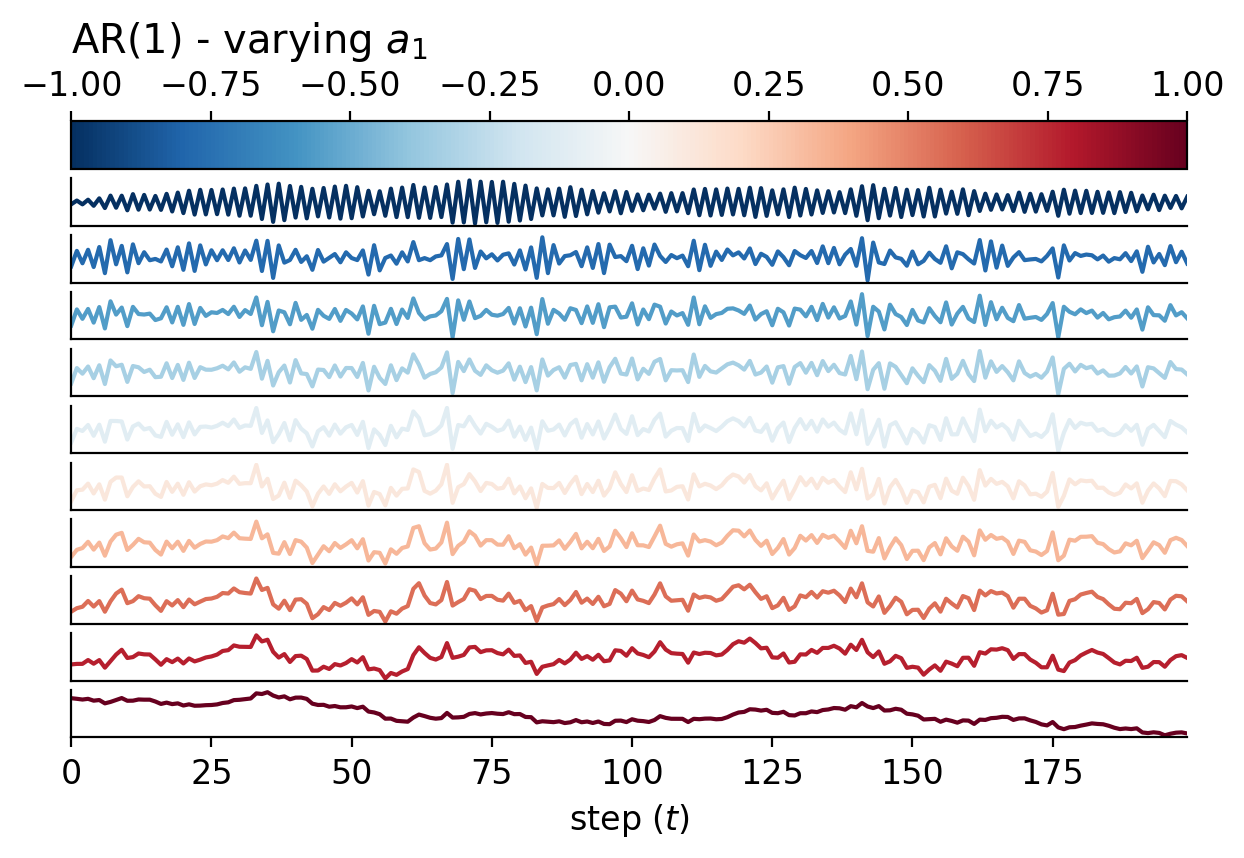

In [10]:
fig = plt.figure(figsize=(7.2, 4.0))
title = "AR(1) - varying $a_1$"
plot_varying_simulations(fig, ar_sims, title=title)
plt.savefig("ar1-samples.png", dpi=300, bbox_inches="tight")

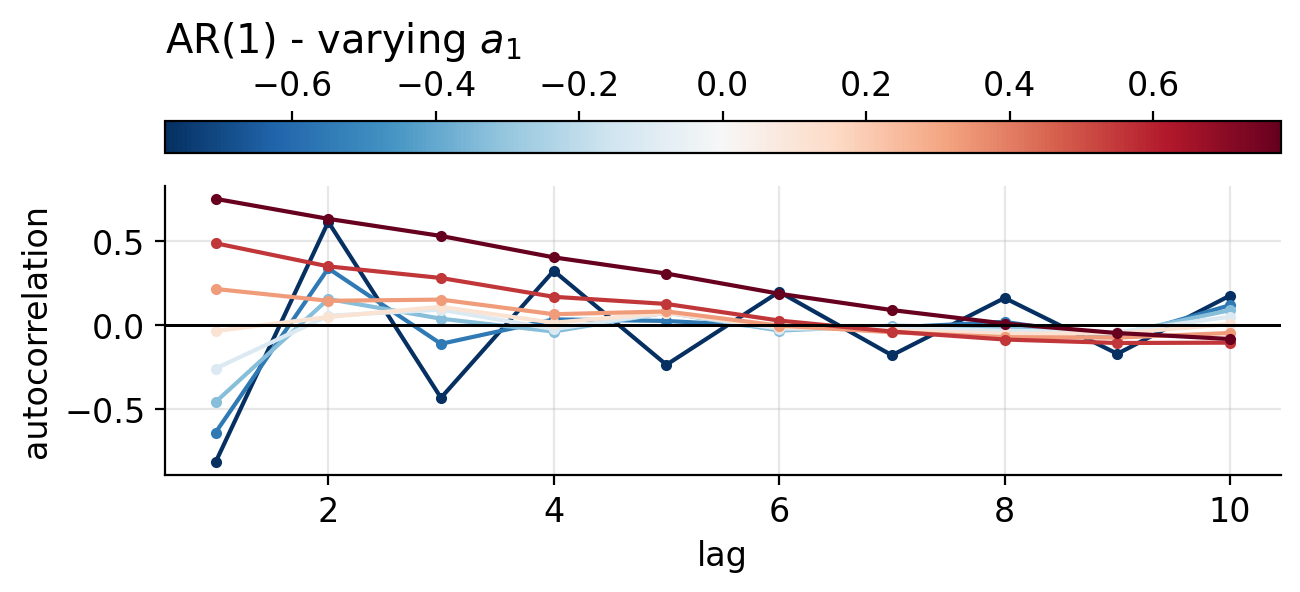

In [11]:
fig = plt.figure()
lags = np.arange(1, 11)
cmap = plt.cm.RdBu_r
title = "AR(1) - varying $a_1$"
plot_simulations_autocorrelation(fig, ar_sims.iloc[:, 1:-1], lags, cmap, title, "continous")
plt.savefig("ar1-samples-autocorr.png", dpi=300, bbox_inches="tight")

## MA($m$) process

In [12]:
n_values = 10
ma_sims = {}
n_steps = 200
# H_ma_values = jnp.linspace(-1, 1, n_values)
H_ma_lenghts = jnp.arange(n_values) + 1
b = 1.0
for ell in H_ma_lenghts:
    b_terms = jnp.ones(ell) * b
    H_ma, F_ma, T_m = init_arma_components(H_ma=b_terms)
    hist = run_ssm(key, F_ma, H_ma, T_m, R, n_steps)
    ma_sims[int(ell)] = hist["y"]
ma_sims = pd.DataFrame(ma_sims)

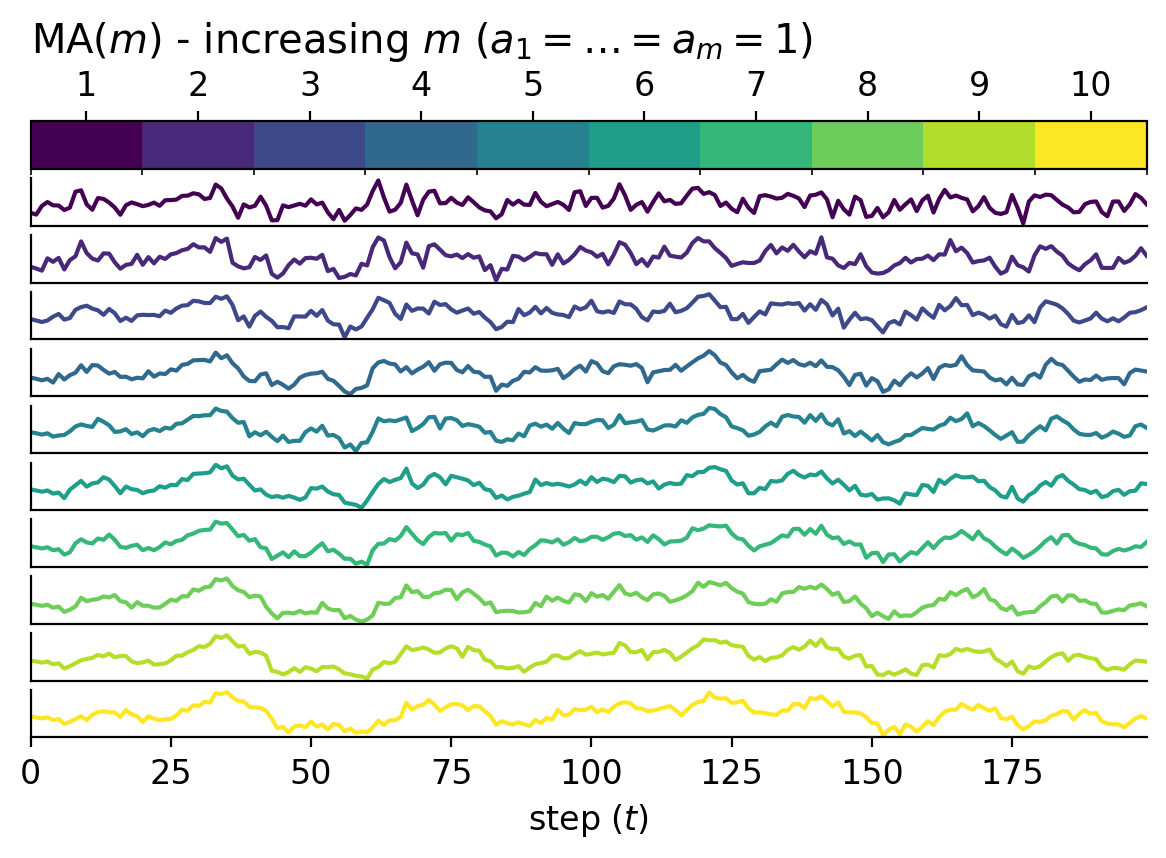

In [13]:
fig = plt.figure(figsize=(7.2, 4.0))
cmap = plt.cm.viridis
title = "MA($m$) - increasing $m$ ($a_1 = \ldots = a_m = 1)$"
plot_varying_simulations(fig, ma_sims, title=title, cmap=cmap, kind="discrete")
plt.savefig("mam-samples.png", dpi=300, bbox_inches="tight")

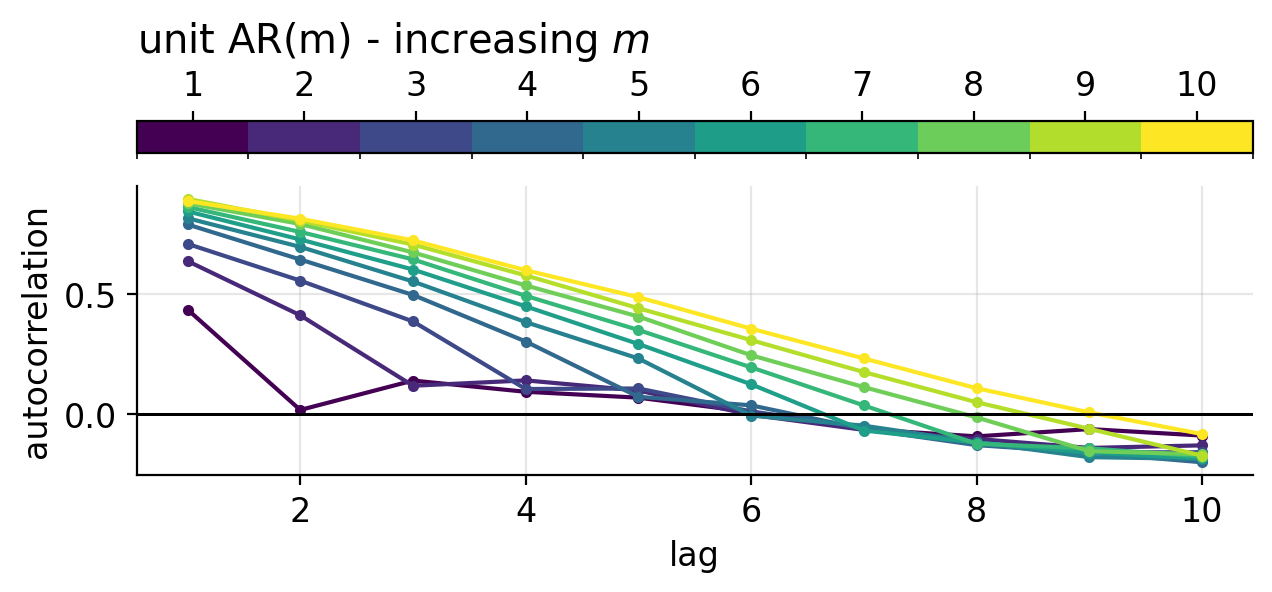

In [14]:
fig = plt.figure()
lags = np.arange(1, 11)
title = "unit AR(m) - increasing $m$"
plot_simulations_autocorrelation(fig, ma_sims, lags, cmap, title, "discrete")
plt.savefig("mam-samples-autocorr.png", dpi=300, bbox_inches="tight")

## ARMA($r$, $m$) process

In [15]:
H_ar = jnp.array([-0.2, 0.3])
H_ma = jnp.ones(10)

H_arma, F_arma, T_arma = init_arma_components(H_ar=H_ar, H_ma=H_ma)

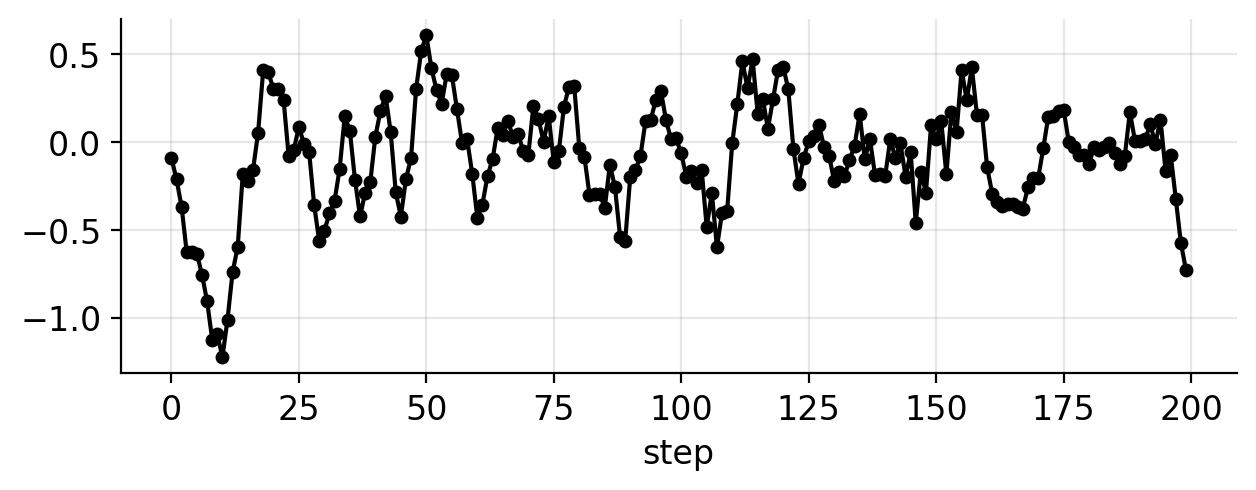

In [16]:
key = jax.random.PRNGKey(314159)

n_steps = 200
hist = run_ssm(key, F_arma, H_arma, T_arma, R, n_steps)

plt.plot(hist["y"], c="black", marker="o", markersize=4)
plt.xlabel("step")
plt.grid(alpha=0.3)

# Filtering components

## 1. Error variance-covariance

In [17]:
def evc_step(Sigma_prev, _, Ft, Ht, Qt, Rt):
    """
    Predict and update step for the error-variance covariance (EVC) matrix
    """
    # Predict EVC matrix
    Sigma_pred = Ft @ Sigma_prev @ Ft.T + Qt
    # innovation variance
    St = Ht @ Sigma_pred @ Ht.T + Rt
    # Update EVC matrix
    C = Sigma_pred @ Ht.T
    Sigma_next = Sigma_pred - C @ jnp.linalg.solve(St, C.T)

    out = {
        "sigma-pred": Sigma_pred,
        "var-innovation": St,
        "sigma-update": Sigma_next
    }
    
    return Sigma_next, out

In [18]:
def arma_evc(n_steps, Sigma_init, H, F, T, R):
    Q = T @ R @ T.T # var(T_{arma} E_{t-1}) = T_{arma} var(E_{t-1}) T_{arma}^T
    H = H[None, :] # (dim-out) X (dim-in)
    timesteps = jnp.arange(n_steps)
    step = partial(evc_step, Ft=F, Ht=H, Qt=Q, Rt=R)
    _, hist = jax.lax.scan(step, Sigma_init, timesteps)
    return hist

In [19]:
H_ar = jnp.array([-0.2, 0.3, 0.6, -0.2])
H_ma = jnp.ones(5) * 0.6

H_ar = jnp.array([0.9,-0.7,0.6])

# H_arma, F_arma, T_arma = init_arma_components(H_ar=H_ar, H_ma=H_ma)
H_arma, F_arma, T_arma = init_arma_components(H_ar=H_ar)

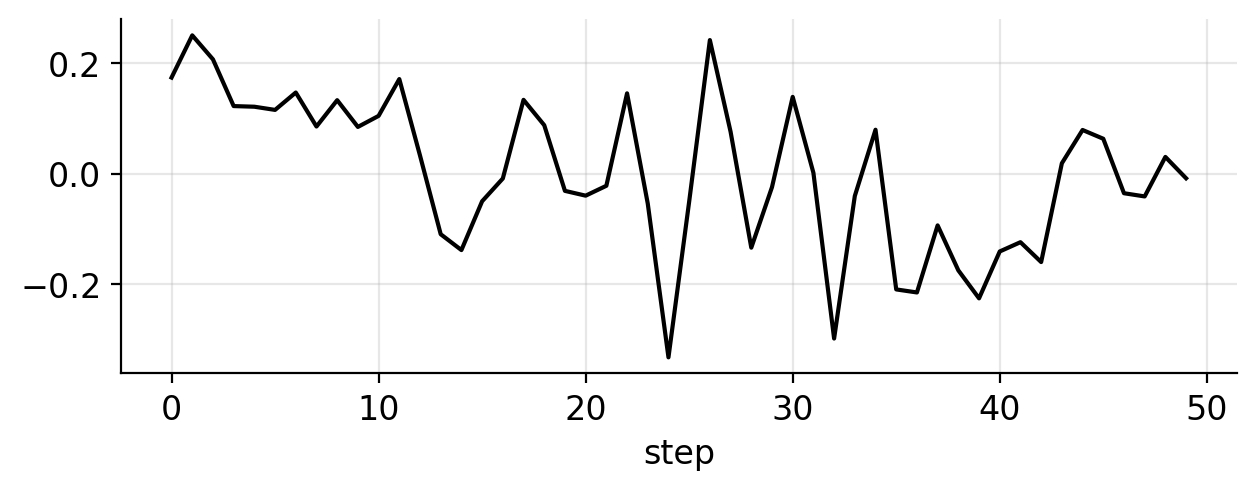

In [20]:
key = jax.random.PRNGKey(31415)
n_steps = 50
R = 0.01 * jnp.eye(1)
hist = run_ssm(key, F_arma, H_arma, T_arma, R, n_steps)
y = hist["y"]

plt.plot(y, c="black", markersize=4)
plt.xlabel("step")
plt.grid(alpha=0.3)

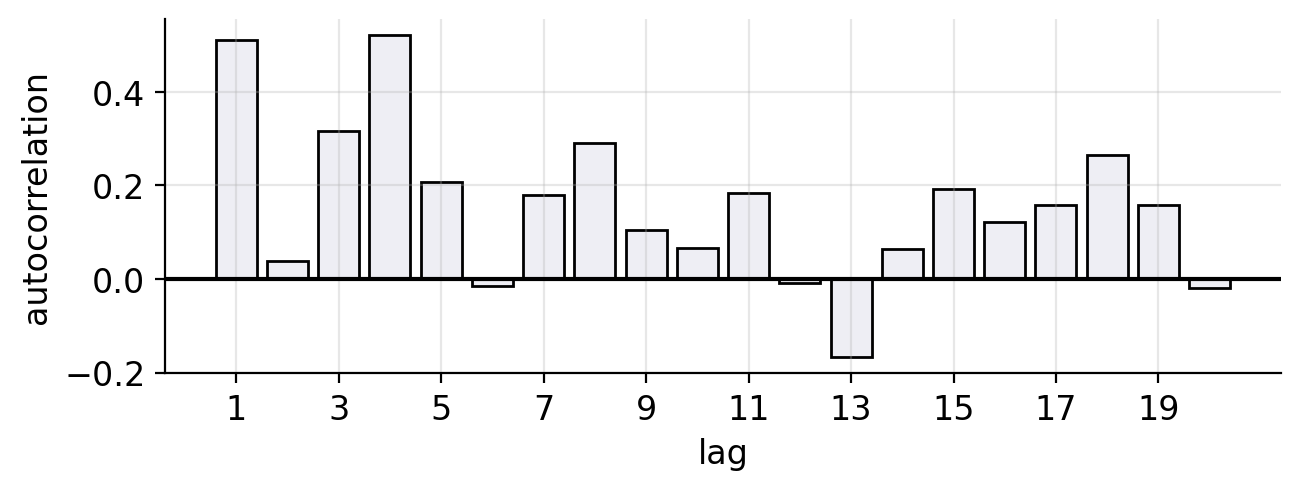

In [21]:
lags = np.arange(1, 21)
autocorr = [pd.Series(y).autocorr(ell) for ell in lags]
plt.bar(lags, autocorr, edgecolor="black", color="#aac3")
plt.ylabel("autocorrelation")
plt.xlabel("lag")
plt.grid(alpha=0.3)
plt.xticks(lags[::2])
plt.axhline(y=0.0, c="black")

## Evaluating error covariance matrix

In [22]:
Sigma_init = jnp.eye(len(F_arma)) * 0.1
hist = arma_evc(n_steps, Sigma_init, H_arma, F_arma, T_arma, R)

## Build components

In [23]:
S_hist = 1 / hist["var-innovation"] # one-dimensional example
Sigma_pred_hist = hist["sigma-pred"]
Sigma_hist = hist["sigma-update"]

In [24]:
H = H_arma[None, :]
M_fwd = jnp.einsum("ij,sjk,lk,slm,mn->sin", F_arma, Sigma_pred_hist, H, S_hist, H)
M_fwd = F_arma[None, ...] - M_fwd

In [25]:
nmask = jnp.ones((n_steps, n_steps))
nmask = jnp.tril(nmask)

In [26]:
timesteps = np.arange(n_steps)

In [27]:
F_backwards = jnp.stack([jnp.linalg.matrix_power(F_arma, s) for s in (timesteps+1)], axis=0)

In [28]:
def backward_elements(t, Sigma_hist, F, H):
    res = []
    for j in range(t):
        part = jnp.linalg.matrix_power(F_arma, j+1) @ Sigma_hist[j] @ H.T
        res.append(part)
    res = jnp.stack(res, axis=0)
    return res


def forward_elements(t, tmax, Sigma_hist, M_hist, H):
    res = []
    Sigma = Sigma_hist[t]
    for j in range(t+1, tmax):
        skip = j - t
        part = jnp.append(Sigma[None, ...], M_hist[t:t+skip], axis=0)
        part = jnp.linalg.multi_dot(part) @ H.T
        res.append(part)
    res = jnp.stack(res, axis=0)
    return res


def back_fwd_elements(t, Sigma_hist, M_hist, F, H):
    tmax = len(Sigma_hist)
    elements = []
    if t > 0:
        back = backward_elements(t, Sigma_hist, F, H)
        elements.append(back)
        
    middle = Sigma_hist[t] @ H.T
    elements.append(middle[None])
    
    if t < tmax-1:
        fwd = forward_elements(t, tmax, Sigma_hist, M_hist, H)
        elements.append(fwd)
    
    elements = np.concatenate(elements)
    return elements

In [29]:
shape = (n_steps, n_steps, *H.T.shape)
fundamental = jnp.zeros(shape)

for t in tqdm(range(n_steps)):
    part = back_fwd_elements(t, Sigma_pred_hist, M_fwd, F_arma, H)
    fundamental = fundamental.at[t].set(part)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  6.02it/s]


<Axes: >

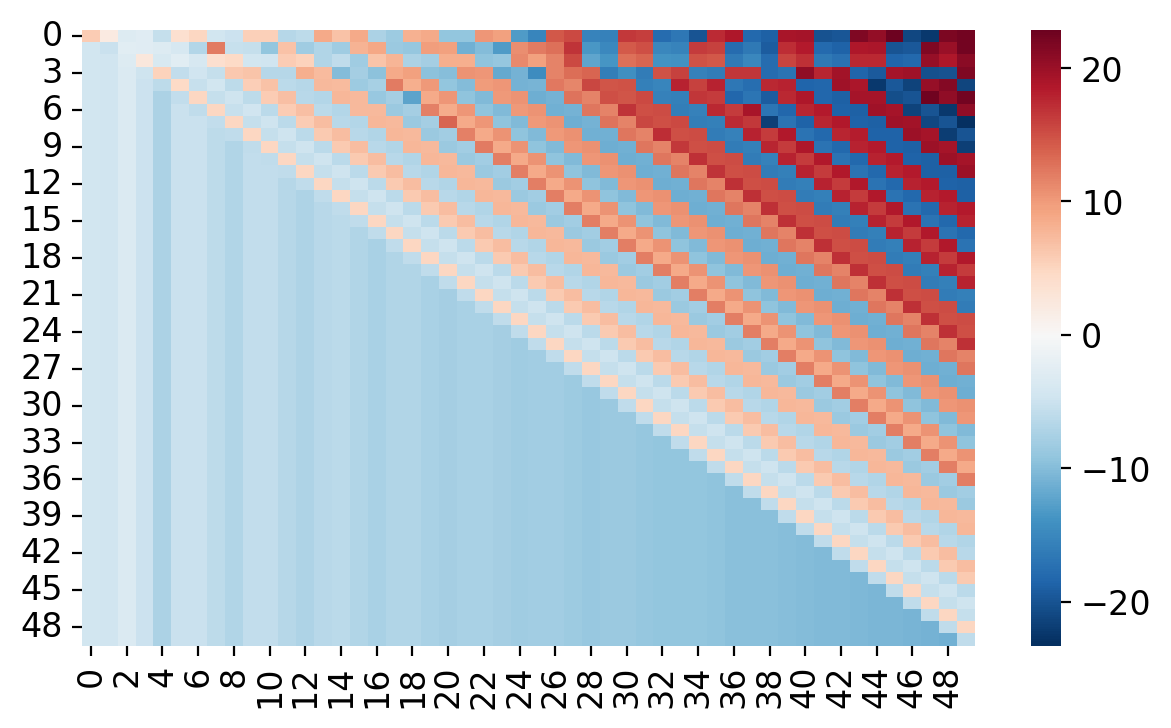

In [30]:
fig, ax = plt.subplots(figsize=(7.2, 4.0))
pf = fundamental.squeeze()[..., 3]
stdpf = jnp.sqrt(jnp.diag(pf))
logpf = jnp.sign(pf) * jnp.log(jnp.abs(pf))
sns.heatmap(logpf, cmap="RdBu_r", center=0)

## The recursive nature of an SSM

$$
\begin{aligned}
    \Theta_{t|t}
    &= \sum_{k=1}^t {\bf K}_{t,k}\,{\cal E}_k\\
    &= \sum_{k=1}^t {\rm Cov}(\Theta_t, {\cal E}_k)\,{\rm Var}({\cal E}_k)^{-1}\,{\cal E}_k\\
    &= \sum_{k=1}^t {\rm Cov}(\Theta_t, {\cal E}_k)\,{\rm Var}({\cal E}_k)^{-1}\,(Y_k - \hat{Y}_k)\\
    &= \sum_{k=1}^t {\rm Cov}(\Theta_t, {\cal E}_k)\,{\rm Var}({\cal E}_k)^{-1}\,(Y_k - {\bf H}_k\,\Theta_{k|k-1})\\
    &= \sum_{k=1}^t {\rm Cov}(\Theta_t, {\cal E}_k)\,{\rm Var}({\cal E}_k)^{-1}\,Y_k - 
    \sum_{k=1}^t {\rm Cov}(\Theta_t, {\cal E}_k)\,{\rm Var}({\cal E}_k)^{-1}\,{\bf H}_k\,\Theta_{k|k-1},
\end{aligned}
$$


Finally,
$$
\begin{aligned}
\Theta_{t|t} &= 
\sum_{k=1}^t {\rm Cov}(\Theta_t, {\cal E}_k)\,{\rm Var}({\cal E}_k)^{-1}\,Y_k-
\sum_{k=1}^t {\rm Cov}(\Theta_t, {\cal E}_k)\,{\rm Var}({\cal E}_k)^{-1}\,{\bf H}_k\,{\bf F}_{k-1}\,\Theta_{k-1|k-1}
\\
&=
\underbrace{
\sum_{k=1}^t {\bf K}_k\,Y_k
}_\text{(T.1)} -
\underbrace{
\sum_{k=1}^t {\bf K}_k\,{\bf H}_k\,{\bf F}_{k-1}\,\Theta_{k-1|k-1}
}_\text{(T.2)}
\end{aligned}
$$

In [31]:
def step(theta_hist, state):
    t, fundamental, tmask = state
    Kt = jnp.einsum("kdo,koo,k->kd", fundamental, S_hist, tmask) # build gain matrix
    t1 = jnp.einsum("kd,k->d", Kt, y)
    t2 = jnp.einsum("kd,dm,ml,kl->d", Kt, H, F_arma, theta_hist)
    theta_new = t1 - t2
    theta_hist = theta_hist.at[t].set(theta_new)
    return theta_hist, Kt

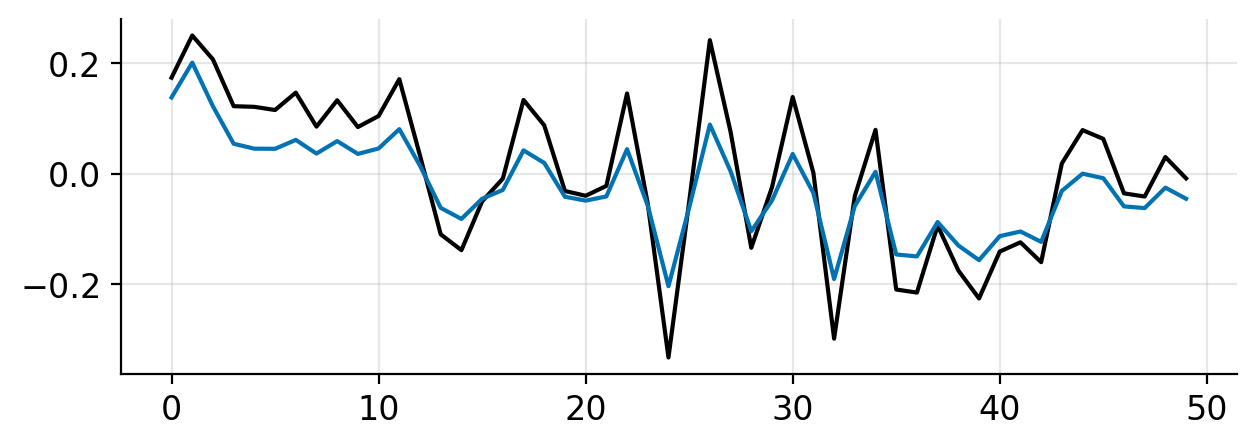

In [32]:
n_components = len(H_arma)
mu0 = jnp.zeros(n_components)
mu_hist = jnp.zeros((n_steps, n_components))
mu_hist = mu_hist.at[0].set(mu0)

# Filtering
tmask = jnp.tril(np.ones((n_steps, n_steps)), k=0)

steps = jnp.arange(n_steps)
hist = (steps, fundamental, tmask)

mu_hist, _ = jax.lax.scan(step, mu_hist, hist)
yhat = jnp.einsum("td,od->t", mu_hist, H)

plt.plot(y, c="black", label="y")
plt.plot(yhat, label="yhat")
plt.grid(alpha=0.3)

## Forecasting

In [33]:
def forecast_step(state, step):
    mu, Sigma, Q_prev = state
    
    mu_next = F_arma @ mu
    Sigma_carry = F_arma @ Sigma @ F_arma.T
    Q_carry = F_arma @ Q_prev @ F_arma.T

    state = (mu_next, Sigma_carry, Q_carry)
    out = (mu_next, Sigma_carry, Q_prev)
    
    return state, out
    

n_forecasts = 20
ix_init = -1
steps = jnp.arange(n_forecasts)
step = partial(forecast_step)
Q = T_arma @ R @ T_arma.T
state_init = (mu_hist[ix_init], Sigma_hist[ix_init], Q)
_, (mu_forecast, Sigma_forecast_carry, Q_carry) = jax.lax.scan(step, state_init, steps)

Sigma_forecast = Sigma_forecast_carry + Q_carry.cumsum(axis=0)

In [34]:
yforecast = jnp.einsum("td,d->t", mu_forecast, H_arma)

In [35]:
stdevforecast = jnp.sqrt(jnp.einsum("i,tij,j->t", H_arma, Sigma_forecast, H_arma))

ubound = yforecast + 1.96 * stdevforecast
lbound = yforecast - 1.96 * stdevforecast

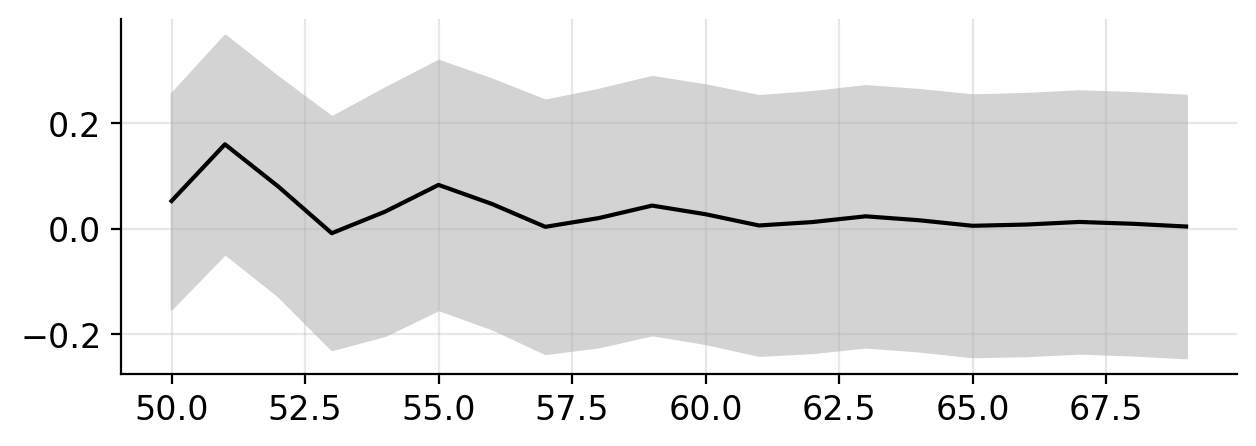

In [36]:
steps_forecasts = jnp.arange(n_forecasts) + n_steps
plt.plot(steps_forecasts, yforecast, c="black")
plt.fill_between(steps_forecasts, lbound, ubound, color="lightgray")

plt.grid(alpha=0.3)

In [37]:
steps_total = jnp.arange(n_steps + n_forecasts)

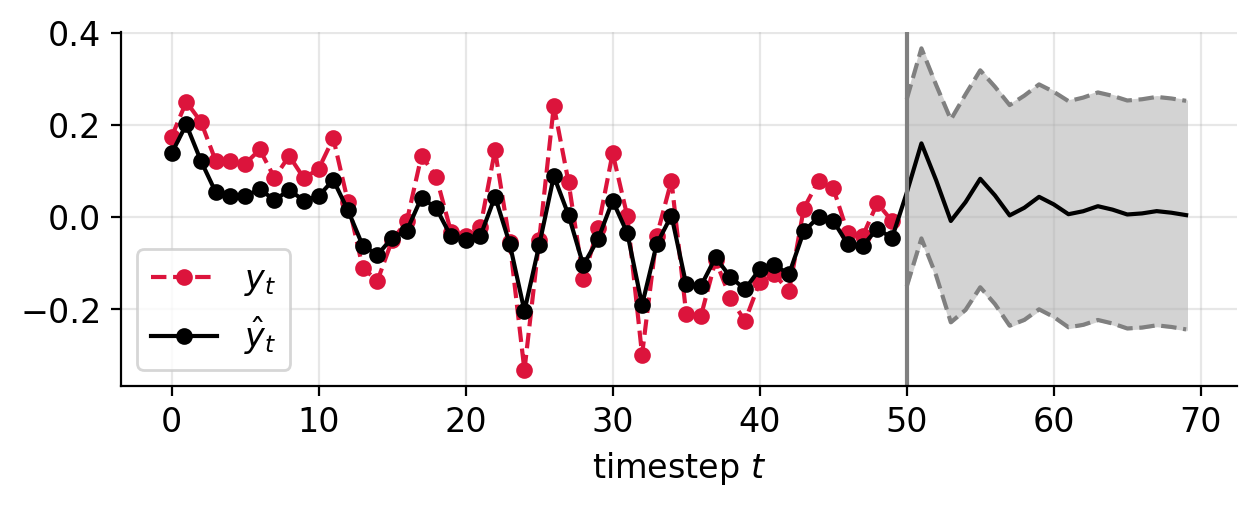

In [38]:
plt.plot(y, c="crimson", linestyle="--", label="$y_t$", marker="o", markersize=5)
plt.plot(jnp.concat([yhat]), label=r"$\hat{y}_t$", c="black", marker="o", markersize=5)

sp1 = jnp.insert(steps_forecasts, 0, steps_forecasts[0] - 1)
yp1 = jnp.insert(yforecast, 0, yhat[-1])
plt.plot(sp1, yp1, c="black")
plt.fill_between(steps_forecasts, lbound, ubound, color="lightgray")
plt.plot(steps_forecasts, ubound, c="gray", linestyle="--")
plt.plot(steps_forecasts, lbound, c="gray", linestyle="--")
plt.axvline(x=n_steps, c="gray")

plt.legend()
plt.xlabel("timestep $t$")
plt.grid(alpha=0.3)
plt.savefig("arma-filter-forecast.png", dpi=300, bbox_inches="tight")